### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

In [2]:
# base
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
    RegressorMixin,
)  # для нашей обёртки YDF

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
)
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    RandomizedSearchCV,
    cross_val_score,
)

# models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import Ridge

# tunning hyperparamters model
import optuna

In [3]:
# Внешние модели: подключаем с защитой (могут быть не установлены)
try:
    from catboost import CatBoostRegressor

    HAS_CAT = True
except Exception as e:
    print("⚠️ CatBoost недоступен:", e)
    HAS_CAT = False

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor

    HAS_LGBM = True
except Exception as e:
    print("⚠️ LightGBM недоступен:", e)
    HAS_LGBM = False

try:
    from xgboost import XGBRegressor

    HAS_XGB = True
except Exception as e:
    print("⚠️ XGBoost недоступен:", e)
    HAS_XGB = False

In [4]:
# YDF (Yggdrasil Decision Forests) ==========================
# Это «движок деревьев» из TF-DF, но без TensorFlow; работает на Windows.
HAS_YDF = False
try:
    import ydf  # pip install ydf

    HAS_YDF = True

    class YDFRegressor(BaseEstimator, RegressorMixin):
        """
        sklearn-совместимая обёртка над YDF.
        Идея: в .fit(X, y) мы собираем единый DataFrame с колонкой лейбла
        и обучаем ydf.*Learner; в .predict(X) — даём DataFrame без лейбла.

        По умолчанию используем GBT (градиентный бустинг). Можно переключить на RF.
        """

        def __init__(
            self,
            algo: str = "gbt",  # "gbt" или "rf"
            num_trees: int = 600,  # число деревьев
            max_depth: int | None = None,
            shrinkage: float | None = 0.05,  # learning_rate (для GBT)
            subsample: float | None = 0.8,  # подвыборка для GBT
            l2_regularization: float | None = None,
            random_seed: int = 42,
        ):
            self.algo = algo
            self.num_trees = num_trees
            self.max_depth = max_depth
            self.shrinkage = shrinkage
            self.subsample = subsample
            self.l2_regularization = l2_regularization
            self.random_seed = random_seed
            self._model = None  # сюда положим обученную модель

        def fit(self, X, y):
            # 1) Преобразуем X в DataFrame (важно для ydf)
            X_df = pd.DataFrame(X).copy()
            # 2) YDF ожидает, что лейбл — отдельная именованная колонка.
            X_df["__target__"] = np.asarray(y)

            # 3) Выбираем тип алгоритма
            if self.algo == "rf":
                learner = ydf.RandomForestLearner(
                    label="__target__",
                    task=ydf.Task.REGRESSION,
                    num_trees=self.num_trees,
                    max_depth=self.max_depth,
                    random_seed=self.random_seed,
                )
            else:
                learner = ydf.GradientBoostedTreesLearner(
                    label="__target__",
                    task=ydf.Task.REGRESSION,
                    num_trees=self.num_trees,
                    max_depth=self.max_depth,
                    shrinkage=self.shrinkage,
                    subsample=self.subsample,
                    l2_regularization=self.l2_regularization,
                    random_seed=self.random_seed,
                )

            # 4) Обучаем модель на табличке
            self._model = learner.train(X_df)
            return self

        def predict(self, X):
            if self._model is None:
                raise RuntimeError("Сначала вызовите .fit(...)")
            X_df = pd.DataFrame(X).copy()
            # YDF возвращает pandas.Series/np.ndarray — приведём к np.ndarray
            preds = self._model.predict(X_df)
            return np.asarray(preds, dtype=float)

except Exception as e:
    print("⚠️ YDF недоступен:", e)
    HAS_YDF = False

⚠️ YDF недоступен: No module named 'ydf'


In [5]:
# Показать все колонки без ограничений
pd.set_option("display.max_columns", None)

### Загрузка данных

In [6]:
df = pd.read_csv(
    "train.csv"
)

In [7]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# проверка типов даных и пропусков
pd.DataFrame(
    {
        "NaN": df.isna().sum(),
        "NaN_ratio": df.isna().sum() * 100 / len(df),
        "Uniq": df.nunique(),
        "types": df.dtypes,
    }
).query("NaN != 0").sort_values(ascending=False, by="NaN")

,NaN,NaN_ratio,Uniq,types
PoolQC,1453,99.520548,3,object
MiscFeature,1406,96.301370,4,object
Alley,1369,93.767123,2,object
Fence,1179,80.753425,4,object
MasVnrType,872,59.726027,3,object
FireplaceQu,690,47.260274,5,object
LotFrontage,259,17.739726,110,float64
GarageType,81,5.547945,6,object
GarageYrBlt,81,5.547945,97,float64
GarageFinish,81,5.547945,3,object


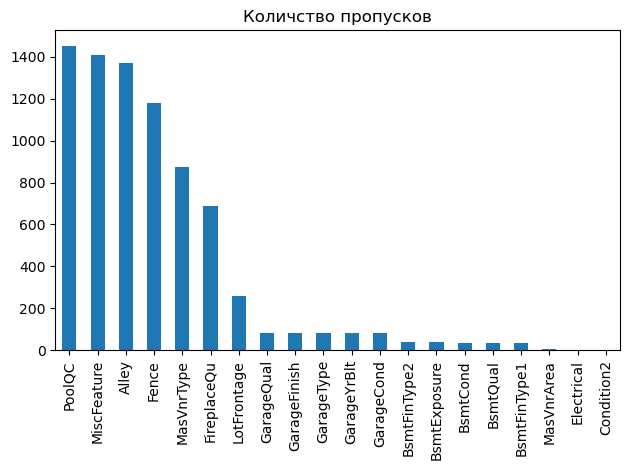

In [9]:
# Смотрим количество пропусков
nan_cols = df.isna().sum().sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Количство пропусков")
plt.tight_layout()

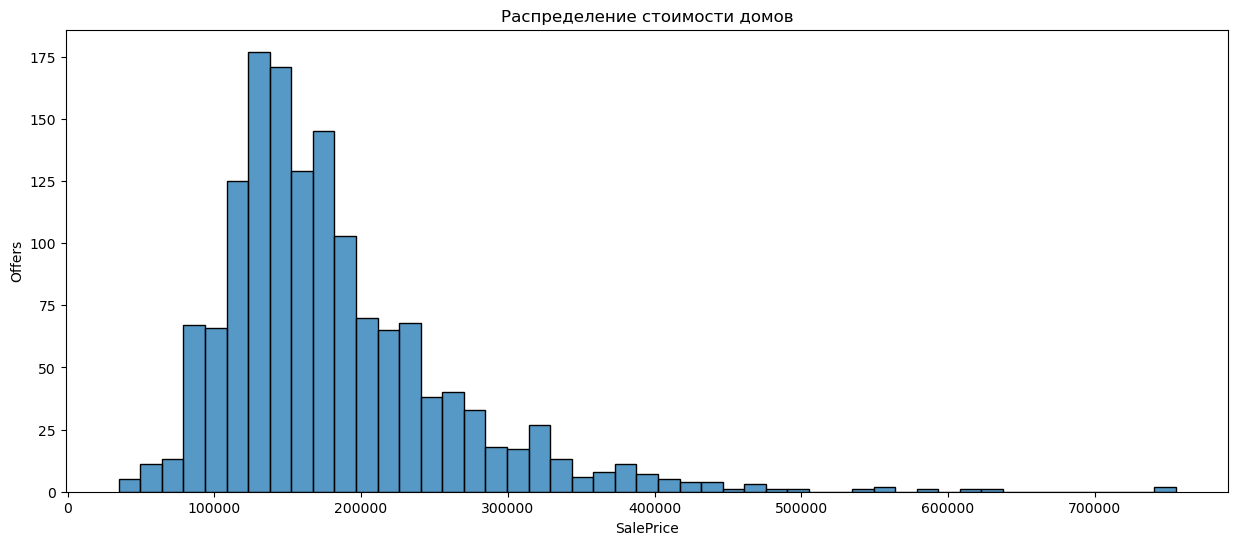

In [10]:
plt.figure(figsize=(15, 6))
sns.histplot(df["SalePrice"])
plt.title("Распределение стоимости домов")
plt.xlabel("SalePrice")
plt.ylabel("Offers")
plt.show()

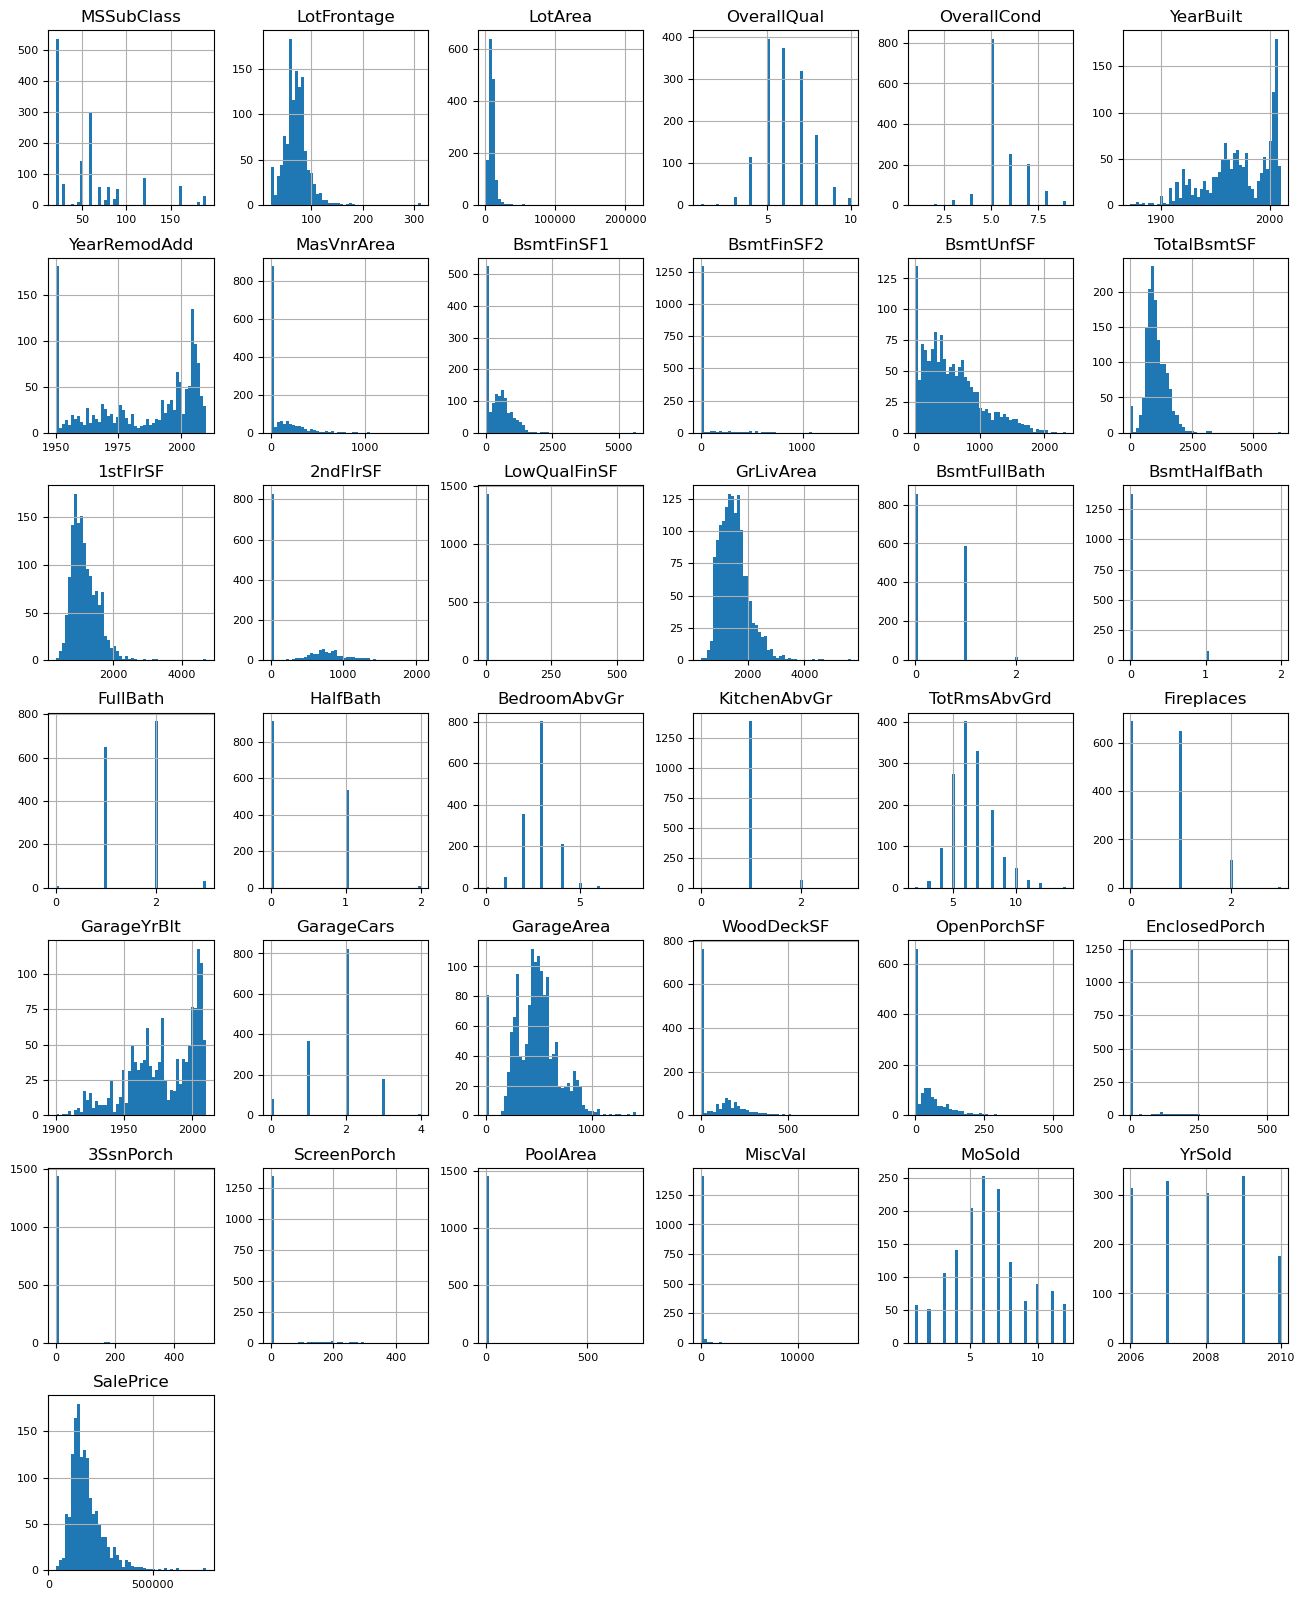

In [12]:
df.select_dtypes(exclude="object").iloc[:, 1:].hist(
    figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8
);

### Предобработка данных

In [13]:
# Удаляем признаки с пропусками в более, чем 80% строк
for_drop = ["PoolQC", "MiscFeature", "Alley", "Fence"]
df = df.drop(columns=for_drop, axis=1).copy()

In [14]:
# Разделим на features (х) и target (у)
X = df.drop(columns=["Id", "SalePrice"])  # признаки
y = np.log1p(df["SalePrice"])  # лог-таргет для устойчивости

* Imputing

In [16]:
# Список признаков для заполнение категорией "NA"
fill_na_col = [
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
]
fill_mean_col    = ['LotFrontage','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']        # среднее
fill_new_cat_col = ["MasVnrType"]  # новая категория "NS"
fill_moda_col    = ['Electrical','FireplaceQu', 'MSSubClass', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']        # мода
# Выделение категорильных и числовых признаков
obj_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
# Разделение fill_na на числовые и категориальные
fill_na_cat = [c for c in fill_na_col if c in obj_cols]
fill_na_num = [c for c in fill_na_col if c in num_cols]
# Переповерка
fill_mean_col = [c for c in fill_mean_col if c in X.columns]
fill_new_cat_col = [c for c in fill_new_cat_col if c in X.columns]
fill_moda_col = [c for c in fill_moda_col if c in X.columns]

In [17]:
# создание Imputer
my_imputer = ColumnTransformer(
    transformers=[
        (
            "fill_na_cat",
            SimpleImputer(strategy="constant", fill_value="NA"),
            fill_na_cat,
        ),
        ("fill_na_num", SimpleImputer(strategy="median"), fill_na_num),
        ("fill_mean", SimpleImputer(strategy="mean"), fill_mean_col),
        (
            "fill_new_cat",
            SimpleImputer(strategy="constant", fill_value="NS"),
            fill_new_cat_col,
        ),
        ("fill_moda", SimpleImputer(strategy="most_frequent"), fill_moda_col),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

* Encoding / scaling

In [18]:
# Список категриальых / числовых признаков
numeric_cols_all = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols_all = X.select_dtypes(include=["object"]).columns.tolist()
# Списки по типу кодировки
ordinal_with_na = ["FireplaceQu", "GarageQual", "GarageCond", "BsmtQual", "BsmtCond"]
ordinal_normal = ["KitchenQual", "HeatingQC", "ExterQual", "ExterCond"]
ordinal_with_na = [c for c in ordinal_with_na if c in X.columns]
ordinal_normal = [c for c in ordinal_normal if c in X.columns]

nominal_cols = [
    c for c in categorical_cols_all if c not in set(ordinal_with_na + ordinal_normal)
]
numeric_cols = numeric_cols_all
# Порядок для кодировки (ordinal)
order_with_na = ["NA", "Po", "Fa", "TA", "Gd", "Ex"]
order_normal = ["Po", "Fa", "TA", "Gd", "Ex"]
ordinal_cols = ordinal_with_na + ordinal_normal
ordinal_categories = [order_with_na] * len(ordinal_with_na) + [order_normal] * len(
    ordinal_normal
)

In [19]:
# создание Encoding
encode_transformer = ColumnTransformer(
    transformers=[
        ("num_scale", StandardScaler(), numeric_cols),
        ("ord_enc", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        # ВАЖНО: в sklearn>=1.4 параметр 'sparse' удалён → используем 'sparse_output'
        # ("ohe",       OneHotEncoder(handle_unknown="ignore", sparse_output=False), nominal_cols),
    ],
    verbose_feature_names_out=False,
    remainder="drop",
)

In [20]:
# Общий препроцессор
preprocessor = Pipeline(
    steps=[
        ("imputer", my_imputer),
        ("encode", encode_transformer),
    ]
)

### Train/Valid split

In [63]:
# Разделение на обучающую и тестирующую выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
Y_MIN, Y_MAX = float(y.min()), float(y.max())  # диапазон для обратного log1p

### Метрики (лог-RMSE и RMSE в $)

In [64]:
# Функция для расчета RMSE
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(mean_squared_error(y_true_log, y_pred_log)))

In [65]:
def rmse_dollars(y_true_log, y_pred_log, y_min=Y_MIN, y_max=Y_MAX, margin=0.5):
    y_pred_log_clip = np.clip(y_pred_log, y_min - margin, y_max + margin)
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log_clip)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [66]:
# Считаем метрику RMLSE
def rmlse(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

### Кросс-валидация: RepeatedKFold 5×3

In [67]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

### Конструктор пайплайна

In [68]:
def make_pipe(model):
    return Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

### Модели

In [69]:
ridge_pipe = make_pipe(Ridge(alpha=1.0, random_state=42))

In [70]:
cat_pipe = None
if HAS_CAT:
    cat_pipe = make_pipe(
        CatBoostRegressor(
            loss_function="RMSE",
            iterations=1000,
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=3.0,
            random_state=42,
            verbose=False,
            allow_writing_files=False,
        )
    )

In [71]:
lgbm_pipe = None
if HAS_LGBM:
    lgbm_pipe = make_pipe(
        LGBMRegressor(
            objective="regression",
            n_estimators=1200,
            learning_rate=0.03,
            max_depth=-1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
        )
    )

In [72]:
xgb_pipe = None
if HAS_XGB:
    xgb_pipe = make_pipe(
        XGBRegressor(
            objective="reg:squarederror",
            n_estimators=900,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
        )
    )

In [73]:
ydf_pipe = None
if HAS_YDF:

    # YDF хорошо работает и по числам (после нашего препроцессора/OHE/скейла)
    # Если захочешь — можно попробовать без OHE (деревьям часто лучше),
    # но тогда YDF надо подавать сырые категориальные столбцы до кодирования.
    ydf_pipe = make_pipe(
        YDFRegressor(
            algo="gbt",
            num_trees=800,
            max_depth=5,
            shrinkage=0.05,
            subsample=0.8,
            random_seed=42,
        )
    )

### Универсальная функция обучения/оценки

In [74]:
def fit_and_report(name, pipe):

    # CV по лог-RMSE
    cv_scores = cross_val_score(
        pipe, X_train, y_train, scoring="neg_mean_squared_error", cv=rkf, n_jobs=-1
    )
    cv_rmse_log = float(np.sqrt(-cv_scores).mean())

    # Финальный фит
    pipe.fit(X_train, y_train)

    # Метрики на train/valid
    y_pred_train_log = pipe.predict(X_train)
    y_pred_valid_log = pipe.predict(X_valid)

    metrics = {
        "Model": name,
        "CV_RMSE_log(5x3)": cv_rmse_log,
        "Train_RMSE_log": rmse_log(y_train, y_pred_train_log),
        "Train_RMSE_$": rmse_dollars(y_train, y_pred_train_log),
        "Valid_RMSE_log": rmse_log(y_valid, y_pred_valid_log),
        "Valid_RMSE_$": rmse_dollars(y_valid, y_pred_valid_log),
    }
    return metrics, pipe

### Запуск и таблица результатов

In [75]:
results = []
trained_models = {}

for name, pipe in [
    ("Ridge", ridge_pipe),
    ("CatBoost", cat_pipe),
    ("LightGBM", lgbm_pipe),
    ("XGBoost", xgb_pipe),
    ("YDF", ydf_pipe),  # вместо TFDF
]:
    if pipe is None:
        continue
    print(f"▶ Обучаем {name} (RepeatedKFold 5x3 + train/valid)...")
    m, fitted = fit_and_report(name, pipe)
    results.append(m)
    trained_models[name] = fitted

results_df = (
    pd.DataFrame(results)
    .set_index("Model")
    .loc[
        :,
        [
            "CV_RMSE_log(5x3)",
            "Train_RMSE_log",
            "Train_RMSE_$",
            "Valid_RMSE_log",
            "Valid_RMSE_$",
        ],
    ]
    .sort_values("Valid_RMSE_log")
)

print("\n===== Сравнение моделей =====")
display(results_df)

▶ Обучаем Ridge (RepeatedKFold 5x3 + train/valid)...
▶ Обучаем CatBoost (RepeatedKFold 5x3 + train/valid)...
▶ Обучаем LightGBM (RepeatedKFold 5x3 + train/valid)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 44
[LightGBM] [Info] Start training from score 12.030658
▶ Обучаем XGBoost (RepeatedKFold 5x3 + train/valid)...

===== Сравнение моделей =====


,CV_RMSE_log(5x3),Train_RMSE_log,Train_RMSE_$,Valid_RMSE_log,Valid_RMSE_$
Model,,,,,
CatBoost,0.127982,0.031096,5750.697064,0.138780,28915.517770
XGBoost,0.131189,0.018389,3360.288432,0.139798,28344.591766
LightGBM,0.137280,0.013594,4127.813157,0.147326,30964.174882
Ridge,0.156774,0.139851,34030.779002,0.151803,29052.188865
